In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
today=datetime.today().strftime('%Y-%m-%d')

from tqdm import tqdm # progress apply :)
tqdm.pandas()

%load_ext autoreload
%autoreload 2
def d(l):
    pd.set_option('display.max_colwidth', l)

d(10)

In [3]:
df=pd.read_json("2025-04-26 Merged_Data.json")
#df["year"]=pd.to_datetime(df.Year,format="%Y", errors='coerce')
# Mapping sentiment scores to categories
df["category"]=df["category"].str.lower().fillna("none")


from ast import literal_eval
columns_to_convert=['fields', 'most_common_fields', 'NoStopwords', 'Nouns_Verbs', 'all_jobs','keywords_likely',
       'keywords_only', 'keywords_filtered']

def safe_literal_eval(val):
    try:
        return literal_eval(val)  # Attempt to parse the value
    except (ValueError, SyntaxError, TypeError):
        return val  # Return the original value if parsing fails
# Create a dictionary of converters
converters = {col: safe_literal_eval for col in columns_to_convert}

for col in columns_to_convert:
    if col in df.columns:  # Ensure the column exists in the DataFrame
        df[col] = df[col].apply(safe_literal_eval)
df.shape

(1015, 59)

In [13]:
df.columns

Index(['name', 'Doi', 'journal_x', 'Title', 'Date', 'Year', 'Type',
       'Type Recoded', 'confirmed_2024', '9. retained for analysis (revised)',
       'path_x', 'folder_x', 'journal_y', 'texts_x', 'labels_x',
       'retraction_counts_x', 'has_retraction_x', 'retract_tokens_x',
       'has_retraction_label_x', 'filtered_texts', 'neighboring_texts',
       'texts_until_section_header', 'text', 'relevant', 'retraction_context',
       'retraction_explanation', 'category', 'explanation', 'contains_country',
       'country_plus_city', 'Most Common country', 'all_jobs', 'fields',
       'most_common_fields', 'path_y', 'folder_y', 'journal', 'texts_y',
       'labels_y', 'retraction_counts_y', 'has_retraction_y',
       'retract_tokens_y', 'has_retraction_label_y', 'text_y', 'sentiment',
       'keywords_likely', 'keywords_only', 'keywords_filtered', 'Lemmata',
       'NoStopwords', 'Nouns_Verbs', 'misconduct', 'mistake', 'retract',
       'n_misconduct', 'n_mistake', 'n_retract', 'dict_

In [5]:
# Filter Text Duplications
duplicated=df[df.text.duplicated(keep=False) | (df.Doi.duplicated(keep=False))]
duplicated=duplicated[duplicated.Doi!=0]
duplicated[["text","Doi"]].to_excel("2025-04-02 Duplicated Texts.xlsx")
df.drop_duplicates(subset="text",inplace=True)
df.shape

(1010, 59)

# Compare annotations

In [7]:

Annotated_Classified=df.dropna(subset="Max code")[["text","category","dict_topic","Max code","explanation"]]
Annotated_Classified.rename(columns={"Max code":"manual category","explanation":" GPT4 explanation","category":"GPT4o-mini category","dict_topic":"dictionary category"},inplace=True)
Annotated_Classified=Annotated_Classified.dropna()
from sklearn.metrics import classification_report
report1=classification_report(Annotated_Classified["manual category"], Annotated_Classified["GPT4o-mini category"], output_dict=True)
r1=(pd.DataFrame(report1).transpose())
report2=classification_report(Annotated_Classified["manual category"], Annotated_Classified["dictionary category"], output_dict=True)
r2=(pd.DataFrame(report2).transpose())

In [9]:
print("dictionary")
r2

dictionary


,precision,recall,f1-score,support
misconduct,0.944444,0.576271,0.715789,59.000000
mistake,0.411765,0.538462,0.466667,13.000000
none,0.386364,0.680000,0.492754,25.000000
accuracy,0.597938,0.597938,0.597938,0.597938
macro avg,0.580858,0.598244,0.558403,97.000000
weighted avg,0.729219,0.597938,0.624918,97.000000


In [11]:
print("GPT4o-mini")
r1

GPT4o-mini


,precision,recall,f1-score,support
misconduct,0.931034,0.915254,0.923077,59.000000
mistake,0.700000,0.538462,0.608696,13.000000
none,0.793103,0.920000,0.851852,25.000000
accuracy,0.865979,0.865979,0.865979,0.865979
macro avg,0.808046,0.791239,0.794541,97.000000
weighted avg,0.864522,0.865979,0.862586,97.000000


In [13]:
df['fields'] = df['fields'].apply(lambda d: d if isinstance(d, list) else [])
df['contains_country'] = df['contains_country'].apply(lambda d: d if isinstance(d, list) else [])

In [15]:
Articles_with_fields=df.fields.apply(lambda x: False if len(x) == 0 or x[0] is None else True).value_counts()
Articles_with_country=df.contains_country.apply(lambda x: False if len(x) == 0 or x[0] is None else True).value_counts()
print(f"There are {Articles_with_fields[True]} articles with fields in the corpus and {Articles_with_country[True]} articles with a country.")

There are 471 articles with fields in the corpus and 481 articles with a country.


In [17]:
import pandas as pd
from collections import Counter

# Function to count top 10 countries for each category
def get_top_countries(group):
    # Flatten the list of countries in the group
    all_countries = [country for sublist in group for country in sublist]
    # Count occurrences of each country
    country_counts = Counter(all_countries)
    # Get the 10 most common countries
    return country_counts.most_common(10)

# Group by category and apply the function
top_countries_by_category = df.groupby("category")["contains_country"].apply(get_top_countries)

# Convert the result to a DataFrame for better readability
result_df = top_countries_by_category.apply(pd.Series).stack().reset_index()
result_df.columns = ["category", "rank", "country_count"]
result_df[["country", "count"]] = pd.DataFrame(result_df["country_count"].tolist(), index=result_df.index)
result_df = result_df.drop(columns=["country_count"])

print(result_df)


     category  rank    country  count
0   miscon...     0      China    209
1   miscon...     1      Japan    145
2   miscon...     2    Germany     79
3   miscon...     3  United...     69
4   miscon...     4      India     53
5   miscon...     5     Canada     48
6   miscon...     6  Australia     44
7   miscon...     7     Brazil     36
8   miscon...     8  Nether...     30
9   miscon...     9     France     26
10    mistake     0      China     14
11    mistake     1    Germany      9
12    mistake     2      Japan      9
13    mistake     3  United...      7
14    mistake     4     Canada      5
15    mistake     5  Australia      4
16    mistake     6  South ...      3
17    mistake     7      Italy      3
18    mistake     8     France      3
19    mistake     9     Brazil      3
20       none     0  United...     34
21       none     1  Australia     23
22       none     2      Japan     22
23       none     3      China     16
24       none     4     Brazil     15
25       non

In [86]:
# Create a DataFrame for plotting
dict_topic=df['dict_topic'].str.capitalize().fillna("None").value_counts()
gpt4_topic=df['category'].str.capitalize().fillna("None").value_counts()
sentiment=df['sentiment'].str.capitalize().value_counts()
type_recoded=df['Type Recoded'].str.capitalize().value_counts()
journal=df['journal'].str.capitalize().value_counts()

top_f=5
fields=df["fields"].explode().str.title().value_counts()
top_fields=fields[:top_f]
top_fields["others"]=fields[top_f:].sum()
#top_fields=top_fields.sort_values()

top_c=5
countries_A=df["country_plus_city"].explode().value_counts()
top_countries_A=countries_A[:top_c]
top_countries_A["others"]=countries_A[top_c:].sum()

countries_B=df.contains_country.explode().value_counts()
top_countries_B=countries_B[:top_c]
top_countries_B["others"]=countries_B[top_c:].sum()
countries_included=list(set(top_countries_A.index.append(top_countries_B.index)))

def categorize_decade(year, dmin_year, dmax_year, interval=10):
    # Calculate the start year based on the minimum year
    start_year = dmin_year + ((year - dmin_year) // interval) * interval
    
    # Calculate the end year
    end_year = start_year + interval - 1
    
    # Ensure the end year does not exceed the maximum year
    end_year = min(end_year, dmax_year)
    
    return f"{start_year}-{end_year} ({1+end_year-start_year} years)"

# Create the new column 'Year2' using the min and max year from the DataFrame
min_year, max_year = df['Year'].min(), df['Year'].max()
df['Year2'] = df['Year'].apply(lambda x: categorize_decade(x, min_year, max_year, interval=10))

years=df['Year2'].value_counts()
years.sort_index(inplace=True)

In [88]:
# Combine data into DataFrames
counts_df = pd.DataFrame({'dictionary': dict_topic, 'GPT4o-mini': gpt4_topic,
                          'sentiment': sentiment, 'Type Recoded': type_recoded, "Journal":journal,
                          'top_countries \n(without cities)': top_countries_B,
                          'top_countries \n(with cities)': top_countries_A,
                          'top_fields': top_fields, "years":years})



# To Do: Fix the number of countries represntation 

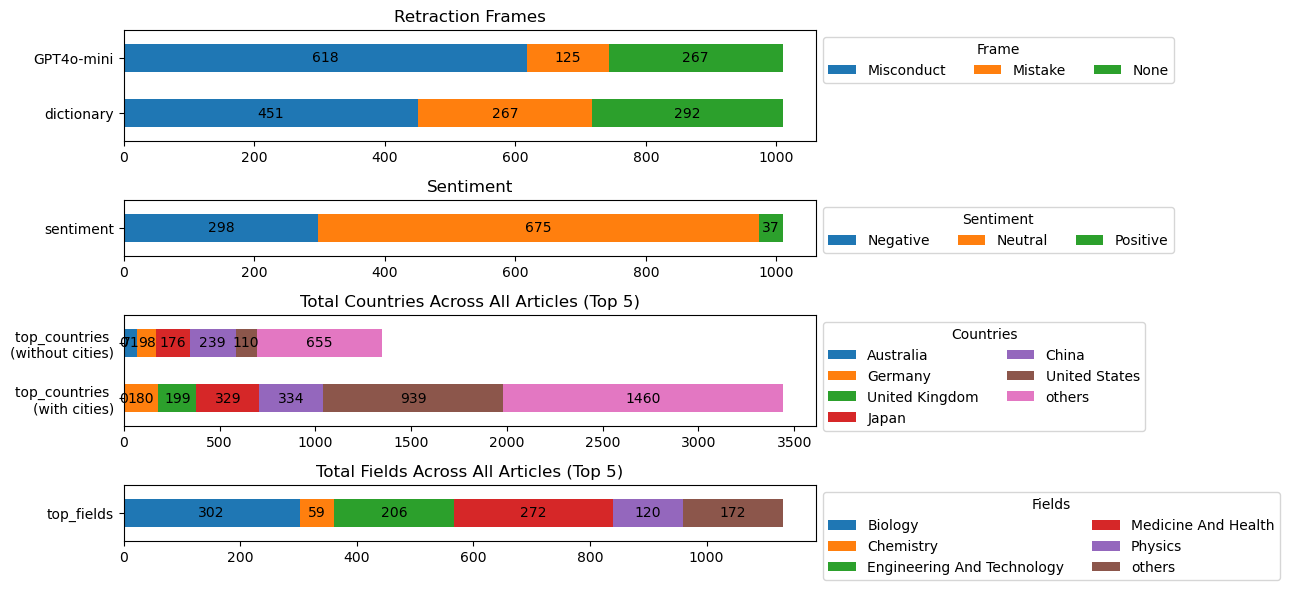

In [324]:
import matplotlib.pyplot as plt

def plot_barh(ax, data, title, legend_title, ncols=3):
    """Helper function to plot horizontal bar charts with annotations."""
    if isinstance(data,pd.Series):
        data=data.to_frame()
    
    bars = data.dropna().T.plot(kind='barh', stacked=True, ax=ax, legend=True)
    ax.set_title(title)
    ax.legend(title=legend_title, loc='upper left', bbox_to_anchor=(1, 1), ncols=ncols)
    
    # Annotate the bars with percentages
    for bar in bars.containers:
        ax.bar_label(bar, label_type='center')

# Define the plots and their titles
plot_configs = [
    (counts_df[["dictionary", "GPT4o-mini"]], 'Retraction Frames', 'Frame',3),
    (counts_df["sentiment"], 'Sentiment', 'Sentiment',3),
   # (counts_df["Type Recoded"], 'Type Recoded', 'Type Recoded',1),
#    (counts_df["Journal"], 'Journal', 'Journal'),
    (counts_df.loc[countries_included][['top_countries \n(with cities)', 'top_countries \n(without cities)']].fillna(0).sort_values('top_countries \n(with cities)'), 
     'Total Countries Across All Articles (Top 5)', 'Countries',2),
    (counts_df["top_fields"], 'Total Fields Across All Articles (Top 5)', 'Fields',2),
  #  (counts_df["years"], 'Years', 'Years',1)
]

# Create height ratios based on the number of columns in each plot
height_ratios = [1 if isinstance(config[0],pd.Series) else 2 for config in plot_configs]

# Create subplots based on the number of configurations
num_plots = len(plot_configs)
fig, axes = plt.subplots(num_plots, 1, figsize=(13, 6), sharex=False, 
                         gridspec_kw={'height_ratios': height_ratios})

# Loop through the configurations to create plots
for ax, (data, title, legend_title,ncols) in zip(axes, plot_configs):
    plot_barh(ax, data, title, legend_title,ncols)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.savefig("2025-04-02 BarPlot.pdf")
plt.show()


/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/2750389690.py:33: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)


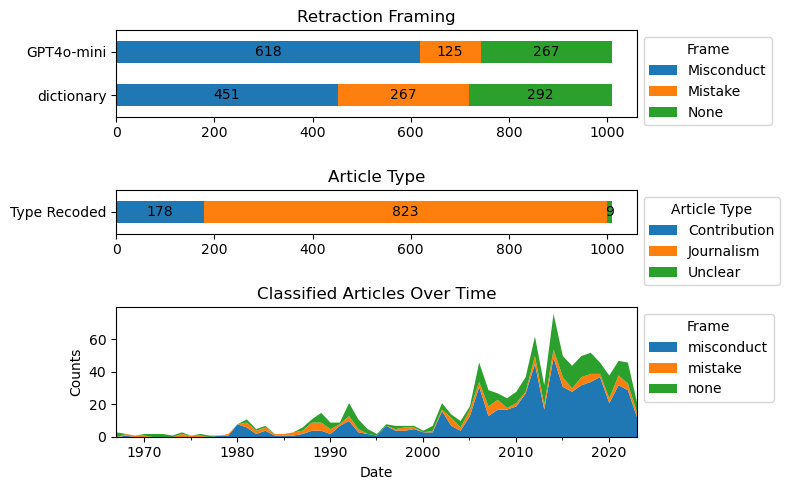

In [96]:


# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=False, gridspec_kw={'height_ratios': [2,1,3]})

# Plot the first bar plot (dict_topic and GPT4_topic)
bars1=counts_df[["dictionary","GPT4o-mini"]].dropna().T.plot(kind='barh', stacked=True, ax=axes[0], legend=True)
axes[0].set_title('Retraction Framing')
#axes[0].set_ylabel('Counts')
axes[0].legend(title='Frame', loc='upper left', bbox_to_anchor=(1, 1))

# Annotate the bars with percentages
for bar in bars1.containers:
    axes[0].bar_label(bar, label_type='center')

# Plot the 3 bar plot (Type Recoded)
bars2=counts_df["Type Recoded"].to_frame().dropna().T.plot(kind='barh', stacked=True, ax=axes[1], legend=True)
axes[1].set_title('Article Type')
#axes[1].get_yaxis().set_visible(False)
#axes[1].set_ylabel('Article Type')
axes[1].legend(title='Article Type', loc='upper left', bbox_to_anchor=(1, 1),ncols=1)

# Annotate the sentiment bars with percentages
for bar in bars2.containers:
    axes[1].bar_label(bar, label_type='center')


dfY = df[(df.Date > pd.Timestamp("1966-01-01")) & 
         (df.Date < pd.Timestamp("2024-01-01"))]
dfY.set_index('Date', inplace=True)



# Resample and count occurrences of each category for the first plot
history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)
history_GPT.plot.area(ax=axes[2], title="Classified Articles Over Time",lw=0)
axes[2].set_ylabel('Counts')
axes[2].legend(title='Frame', loc='upper left', bbox_to_anchor=(1, 1),ncols=1)

# Adjust layout
plt.tight_layout()
plt.show()

In [98]:
df["text_len"]=df.text.str.len()

In [100]:
df["USA_others"] = df["contains_country"].apply(
    lambda x: ["other" if i != "United States" else i for i in x]
)
print(df["USA_others"].explode().value_counts())

df["China_others"] = df["contains_country"].apply(
    lambda x: ["other" if i != "China" else i for i in x]
)
df["Japan_others"] = df["contains_country"].apply(
    lambda x: ["other" if i != "Japan" else i for i in x]
)

df["No_Country"] = df["contains_country"].apply(
    lambda x: True if len(x)==0 else False)

df["Misconduct_others"] = df["category"].apply(
    lambda x: True if x=="misconduct" else False)

print(df["China_others"].explode().value_counts())

USA_others
other            1239
United States     110
Name: count, dtype: int64
China_others
other    1110
China     239
Name: count, dtype: int64


In [102]:
d(500)
df["contains_country"].apply(lambda x: list(set(x))).explode("contains_country")

0               Brazil
1              Germany
2                  NaN
3               Mexico
4              Germany
             ...      
1350    United Kingdom
1351         Indonesia
1352         Australia
1353             India
1354            Canada
Name: contains_country, Length: 1355, dtype: object

In [104]:
df["Type Recoded"]=df["Type Recoded"].replace("Unclear",None)

In [135]:
#dependency of 3 value category (mistake vs. misconduct vs. none)

# List of columns to test against "GPTo-mini"
columns_to_test = ["contains_country",'country_plus_city',"fields",'Type Recoded', 'sentiment','journal',"USA_others","Japan_others","China_others","No_Country"]

def highlight_significant(s):
    return ['background-color: lightgreen' if v < 0.05 else '' for v in s]

def CHI2_tests(df,columns_to_test,dependent_variable='category'):
    from scipy.stats import chi2, chi2_contingency
    
    # Initialize a list to store results
    results_list = []
    crosstabs={}
    
    # Loop through each column and perform the chi-squared test
    for col in columns_to_test:
        try:

            # Check if the column contains list-like values and explode if necessary
            if df[col].apply(lambda x: isinstance(x, list)).any():
               # df[col]=df[col].dropna()
                df[col]=df[col].apply(lambda x: list(set(x))if isinstance(x, list) else [])
                dfx=df.explode(col)  # Create a set and explode the DataFrame if the column contains multiple values
                mc5 = dfx[col].value_counts()[:5].index.to_list()  # Get the top 5 values
                dfx = dfx[dfx[col].isin(mc5)] # Filter the DataFrame to include only top 5 values
                crosstab = pd.crosstab(dfx[col], dfx[dependent_variable])
            else:
                crosstab = pd.crosstab(df[col], df[dependent_variable])
        except:
            print(col)
            
        crosstabs[col]=crosstab
        # Perform the chi-squared test
        chi2_stat, p, dof, expected = chi2_contingency(crosstab)
        
        # Calculate the 95% confidence interval
        lower_bound = chi2.ppf(0.025, dof)  # Lower bound for 95% CI
        upper_bound = chi2.ppf(0.975, dof)  # Upper bound for 95% CI
        
        # Append the results to the list
        results_list.append({
            'Column': col,
            'Chi2': chi2_stat,
            'p-value': p,
            'dof': dof,
            "min_counts":  crosstab.min().min()
         #   '95% CI Lower Bound': lower_bound,
         #   '95% CI Upper Bound': upper_bound
        })
    
    # Create a DataFrame from the results list
    results_df = pd.DataFrame(results_list).style.apply(highlight_significant, subset=['p-value'])
    return results_df, crosstabs



In [137]:
CHI2_tests(df,columns_to_test,dependent_variable='category')

(<pandas.io.formats.style.Styler at 0x3007feba0>,
 {'contains_country': category          misconduct  mistake  none
  contains_country                           
  Australia                 34        4    13
  China                     74       10    12
  Germany                   59        8     8
  Japan                     62        6    11
  United States             52        7    22,
  'country_plus_city': category           misconduct  mistake  none
  country_plus_city                           
  China                      80       15    16
  Germany                    71       11    10
  Japan                      75        8    12
  United Kingdom             90       20    22
  United States             276       52   106,
  'fields': category                    misconduct  mistake  none
  fields                                               
  Biology                            123       23    32
  Chemistry                           24       10     8
  Engineering and Tech

In [246]:

results_df,crosstabs=CHI2_tests(df,columns_to_test,dependent_variable='category')
results_df.to_excel("2025_04_02 Statistical Tests_3.xlsx")
results_df

,Column,Chi2,p-value,dof,min_counts
0,contains_country,12.914943,0.114810,8,4
1,country_plus_city,19.858290,0.010886,8,8
2,fields,8.931427,0.348114,8,8
3,Type Recoded,42.442340,0.000000,2,34
4,sentiment,28.233287,0.000011,4,3
5,journal,1.329669,0.514359,2,43
6,USA_others,1.725761,0.421945,2,7
7,Japan_others,5.404477,0.067055,2,6
8,China_others,5.510928,0.063579,2,10
9,No_Country,10.564533,0.005081,2,57


In [232]:
dependet_variable='category'
results_df,crosstabs=CHI2_tests(df.replace("none",None),columns_to_test,dependent_variable=dependet_variable)
results_df.to_excel("2025_03_27 Statistical Tests_2.xlsx")
results_df


,Column,Chi2,p-value,dof,min_counts
0,contains_country,0.508577,0.972661,4,4
1,country_plus_city,3.089746,0.542921,4,8
2,fields,4.302322,0.366634,4,8
3,Type Recoded,20.466134,0.000006,1,34
4,sentiment,15.375003,0.000459,2,3
5,journal,0.439164,0.507526,1,43
6,USA_others,0.116801,0.732531,1,7
7,Japan_others,1.690173,0.193578,1,6
8,China_others,0.374718,0.540444,1,10
9,No_Country,1.201795,0.272963,1,57


In [151]:
results_df,crosstabs=CHI2_tests(df.replace("none",None),columns_to_test,dependent_variable='Type Recoded')
results_df


,Column,Chi2,p-value,dof,min_counts
0,contains_country,3.130963,0.536153,4,4
1,country_plus_city,3.826128,0.430048,4,5
2,fields,11.843903,0.018551,4,1
3,Type Recoded,994.171807,0.000000,1,0
4,sentiment,1.230271,0.540568,2,8
5,journal,0.821964,0.364606,1,60
6,USA_others,0.003468,0.953037,1,11
7,Japan_others,0.972989,0.323936,1,7
8,China_others,0.000000,1.000000,1,12
9,No_Country,13.076483,0.000299,1,63


In [168]:
df.columns

Index(['name', 'Doi', 'journal_x', 'Title', 'Date', 'Year', 'Type',
       'Type Recoded', 'confirmed_2024', '9. retained for analysis (revised)',
       'path_x', 'folder_x', 'journal_y', 'texts_x', 'labels_x',
       'retraction_counts_x', 'has_retraction_x', 'retract_tokens_x',
       'has_retraction_label_x', 'filtered_texts', 'neighboring_texts',
       'texts_until_section_header', 'text', 'relevant', 'retraction_context',
       'retraction_explanation', 'category', 'explanation', 'contains_country',
       'country_plus_city', 'Most Common country', 'all_jobs', 'fields',
       'most_common_fields', 'path_y', 'folder_y', 'journal', 'texts_y',
       'labels_y', 'retraction_counts_y', 'has_retraction_y',
       'retract_tokens_y', 'has_retraction_label_y', 'text_y', 'sentiment',
       'keywords_likely', 'keywords_only', 'keywords_filtered', 'Lemmata',
       'NoStopwords', 'Nouns_Verbs', 'misconduct', 'mistake', 'retract',
       'n_misconduct', 'n_mistake', 'n_retract', 'dict_

In [154]:
results_df,crosstabs=CHI2_tests(df.replace("none",None),columns_to_test,dependent_variable='journal')
results_df.to_excel("2025_03_27 Statistical Tests_4.xlsx")
results_df

,Column,Chi2,p-value,dof,min_counts
0,contains_country,4.693012,0.320271,4,22
1,country_plus_city,6.018350,0.197782,4,30
2,fields,7.082130,0.131611,4,20
3,Type Recoded,0.821964,0.364606,1,60
4,sentiment,0.043522,0.978474,2,14
5,journal,1005.696739,0.000000,1,0
6,USA_others,0.006653,0.934992,1,29
7,Japan_others,0.838240,0.359901,1,24
8,China_others,2.280159,0.131038,1,43
9,No_Country,0.125387,0.723263,1,173


In [210]:
crosstab[["China","United States"]]

contains_country,China,United States
category,,
misconduct,74,52
mistake,10,7
none,12,22


p-value = 0.42194496065357234
chi-value = 1.7257607968874769


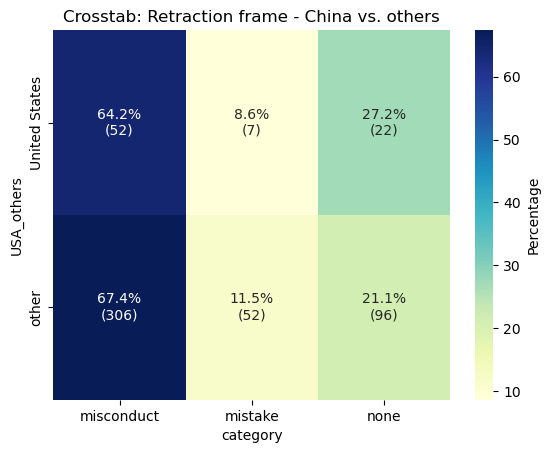

In [274]:
crosstab=crosstabs['USA_others'].T

import seaborn as sns



percentages = crosstab.T.apply(lambda r: r/r.sum().sum()*100, axis=1)

# Create custom annotations
annotations = percentages.round(1).astype(str) + "%" + "\n(" + crosstab.T.astype(str) +")"

# Plot the heatmap
sns.heatmap(percentages, annot=annotations, cmap="YlGnBu", fmt="", cbar_kws={'label': 'Percentage'})
plt.title("Crosstab: Retraction frame - China vs. others")

from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(crosstab)


print("p-value =", p)
print("chi-value =", c)

In [160]:
import seaborn as sns

<Axes: xlabel='journal', ylabel='Type Recoded'>

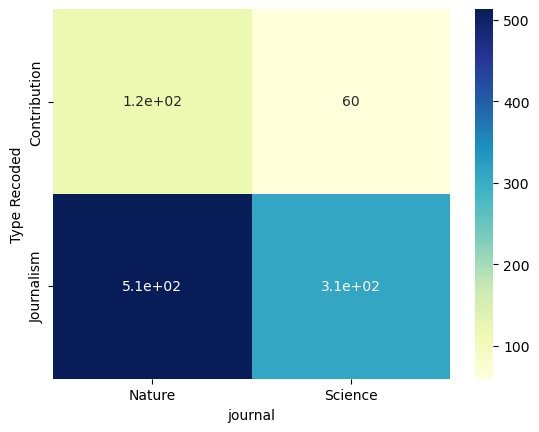

In [162]:
sns.heatmap(crosstabs["Type Recoded"], annot=True, cmap="YlGnBu")

# Time Rows & Correlation

/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3651120801.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)
/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3651120801.py:14: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT5Y = dfY.resample("5Y").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series)
/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3651120801.py:19: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  history_GPT5Y2 = dfY.resample("5Y").apply(lambda x: dict(Counter(x["Type Recoded"]))).apply(pd.Series)


<Axes: title={'center': 'Share of Journal Type in 5-Year Steps'}, xlabel='Date'>

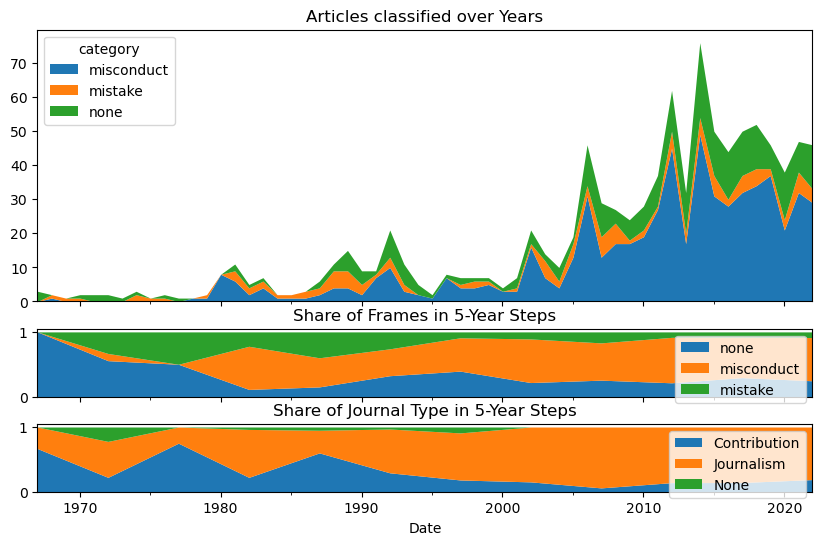

In [326]:
dfY = df[(df.Date > pd.Timestamp("1966-01-01")) & 
         (df.Date < pd.Timestamp("2023-01-01"))]
dfY.set_index('Date', inplace=True)


# Create subplots: 1 column, 2 rows
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})

# Resample and count occurrences of each category for the first plot
history_GPT=dfY.resample('Y').category.value_counts().unstack(level=1)[["misconduct", "mistake", "none"]].fillna(0)
history_GPT.plot.area(ax=axes[0], title="Articles classified over Years",lw=0)

# Resample for 5-year intervals and calculate percentages for the second plot
history_GPT5Y = dfY.resample("5Y").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series)
history_GPT5Y_perc = history_GPT5Y.divide(history_GPT5Y.sum(axis=1), axis=0)
history_GPT5Y_perc.plot.area(ax=axes[1], lw=0, stacked=True, title="Share of Frames in 5-Year Steps")

# Resample for 5-year intervals and calculate percentages for the second plot
history_GPT5Y2 = dfY.resample("5Y").apply(lambda x: dict(Counter(x["Type Recoded"]))).apply(pd.Series)
history_GPT5Y_perc2 = history_GPT5Y2.divide(history_GPT5Y.sum(axis=1), axis=0)
history_GPT5Y_perc2.plot.area(ax=axes[2], lw=0, stacked=True, title="Share of Journal Type in 5-Year Steps")

/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3087609044.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dfY.resample('5Y')["Type Recoded"].value_counts().unstack(level=1).fillna(0).plot.area(stacked=True,linewidth=0,title="Sentences classified over Years")


<Axes: title={'center': 'Sentences classified over Years'}, xlabel='Date'>

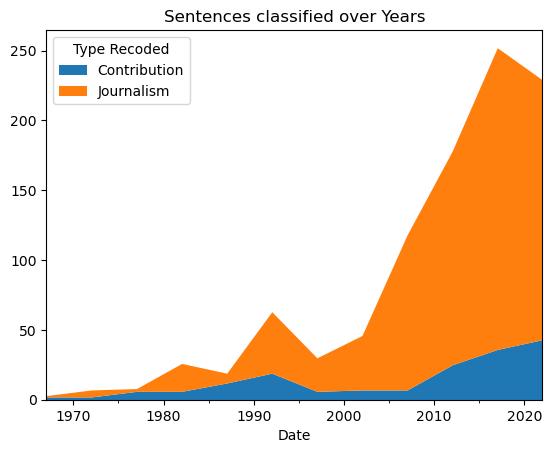

In [328]:
dfY.resample('5Y')["Type Recoded"].value_counts().unstack(level=1).fillna(0).plot.area(stacked=True,linewidth=0,title="Sentences classified over Years")

/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/1098397639.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_counts =dfY.resample('Y').Type.size().fillna(0)


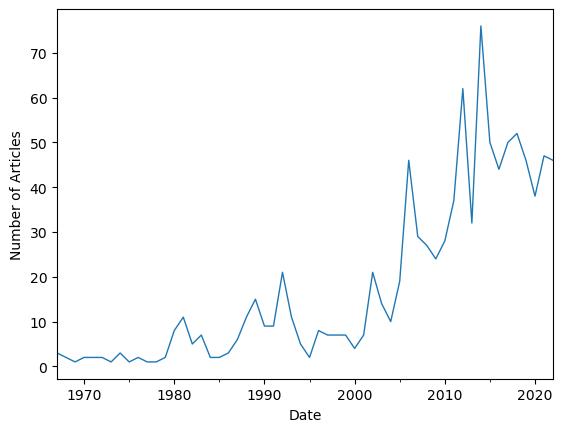

In [332]:
annual_counts =dfY.resample('Y').Type.size().fillna(0)
annual_counts.plot(linewidth=1, ylabel="Number of Articles")
plt.savefig(today+"carticle_Count_yearwise.pdf")

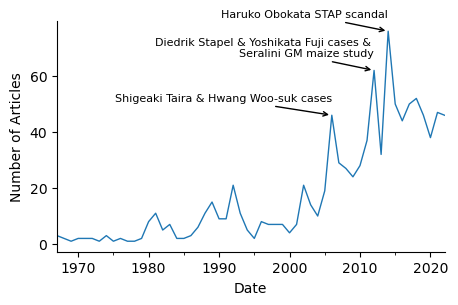

In [330]:
import matplotlib.pyplot as plt

# Assuming `annual_counts` is already defined as in your code
annual_counts = dfY.resample('YE').Type.size().fillna(0)

# Plot the time series
annual_counts.plot(linewidth=1, ylabel="Number of Articles", figsize=(5,3))

# Add annotations for specific years
annotations = {
    2006: "Shigeaki Taira & Hwang Woo-suk cases",
    2012: "Diedrik Stapel & Yoshikata Fuji cases & \nSeralini GM maize study",
    2014: "Haruko Obokata STAP scandal"
}

for year, text in annotations.items():
    # Get the value for the specific year
    value = annual_counts.loc[str(year)].iloc[0]

    
    # Add annotation with an arrow
    plt.annotate(
        text, 
        xy=(pd.Timestamp(str(year)), value),  # Point to the year and its value
        xytext=(pd.Timestamp(str(year)), value + 5),  # Offset the text above the point
        arrowprops=dict(facecolor='black', arrowstyle="->"),
        fontsize=8,
        ha='right'
    )

# Save the plot
import seaborn as sns
sns.despine()
plt.savefig(today + "carticle_Count_yearwise_annotated.pdf")

/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3673176056.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df5Y=dfY.resample("5Y").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series)


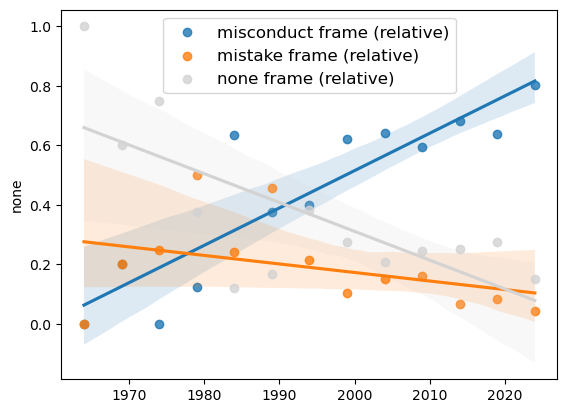

misconduct:  PearsonRResult(statistic=0.8840490849343281, pvalue=6.0600913794614794e-05) 
 mistake:  PearsonRResult(statistic=-0.37297527960306887, pvalue=0.20941136384110554)


In [334]:

## SEABORN REGPLOT With Datetime 

dfY = df[(df.Date > pd.Timestamp("1960-01-01")) & 
         (df.Date < pd.Timestamp("2020-01-01"))]

dfY.set_index('Date', inplace=True)

df5Y=dfY.resample("5Y").apply(lambda x: dict(Counter(x["category"]))).apply(pd.Series)
df5Y_perc=df5Y.divide(df5Y.sum(axis=1), axis=0)

f, ax = plt.subplots()
ax.xaxis.update_units(df5Y_perc.index)


# fill the 100% none frame where there are not many articles wtith 0.
df5Y_perc=df5Y_perc.fillna(0)

sns.regplot(x=ax.xaxis.convert_units(df5Y_perc.index), y=df5Y_perc['misconduct'],label="misconduct frame (relative)")
sns.regplot(x=ax.xaxis.convert_units(df5Y_perc.index), y=df5Y_perc['mistake'],label="mistake frame (relative)")
sns.regplot(x=ax.xaxis.convert_units(df5Y_perc.index), y=df5Y_perc['none'],label="none frame (relative)",color="lightgray")


ax.legend(loc="best")
plt.legend(fontsize=12)
plt.show()

from scipy import stats


df5Y_perc_Year=[i.date().year for i in df5Y_perc.index.to_list()]

Pearson_misconduct=stats.pearsonr(df5Y_perc_Year,df5Y_perc["misconduct"])
Pearson_mistake=stats.pearsonr(df5Y_perc_Year,df5Y_perc["mistake"])
print("misconduct: ",Pearson_misconduct,"\n","mistake: ",Pearson_mistake)

# Statistics with Field & Discipline

<Axes: title={'center': 'Most common countries (1 per article)'}, ylabel='Most Common country'>

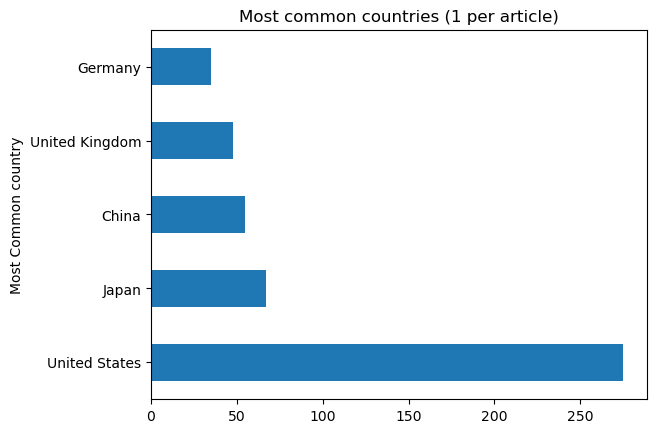

In [336]:
CnF_mcC10=df['Most Common country'].value_counts()[:5]
CnF_mcD10=df['most_common_fields'].explode().value_counts()[:5]
most_common_10countries=CnF_mcC10.index
CnF_mcC10[:10].plot.barh(title="Most common countries (1 per article)")

<Axes: title={'center': 'Most common fields'}, ylabel='most_common_fields'>

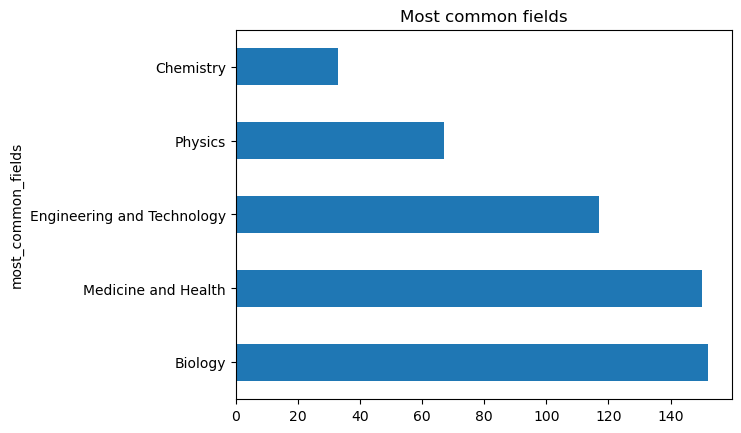

In [340]:
CnF_mcD10=df['most_common_fields'].explode().value_counts()[:5]
most_common_10disciplines=CnF_mcD10.index
CnF_mcD10.plot.barh(title="Most common fields")


In [342]:
CnF_mcC10

Most Common country
United States     275
Japan              67
China              55
United Kingdom     48
Germany            35
Name: count, dtype: int64

In [344]:
df["country_top"]=df['Most Common country'][df['Most Common country'].isin(most_common_10countries)]
df["discipline_top"] = df["most_common_fields"].apply(
    lambda x: [i for i in x if i in most_common_10disciplines] if isinstance(x, list) else []
)

In [346]:
df[["discipline_top","country_top","category","Type Recoded"]]

,discipline_top,country_top,category,Type Recoded
0,[],NaN,none,Journalism
1,[Medicine and Health],NaN,misconduct,Journalism
2,[Chemistry],Germany,mistake,Journalism
3,[],Japan,misconduct,Journalism
4,[Biology],NaN,misconduct,Journalism
...,...,...,...,...
1010,"[Medicine and Health, Engineering and Technology]",United States,misconduct,Journalism
1011,[Medicine and Health],NaN,none,Journalism
1012,[],NaN,misconduct,Journalism
1013,[],NaN,misconduct,Journalism


p-value = 0.21255616721126105
chi-value = 10.812416205218524


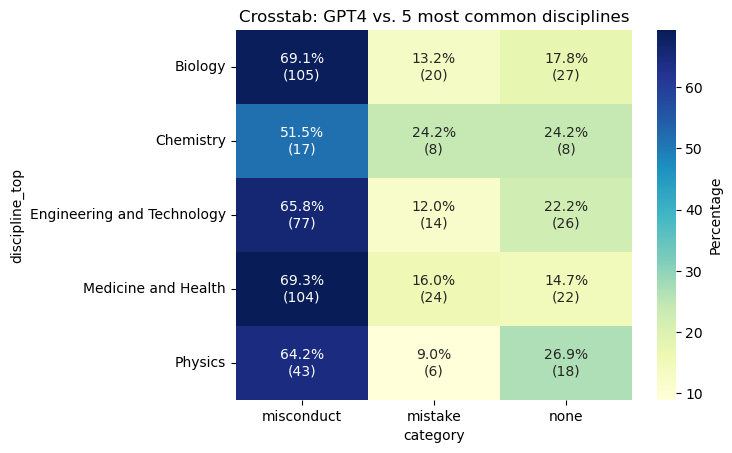

In [348]:

df_exploded=df.explode("discipline_top")[["category","discipline_top"]]


import seaborn as sns
crosstab=pd.crosstab(df_exploded["category"], df_exploded["discipline_top"]).T
percentages = crosstab.apply(lambda r: r/r.sum().sum()*100, axis=1)

# Create custom annotations
annotations = percentages.round(1).astype(str) + "%" + "\n(" + crosstab.astype(str) +")"

# Plot the heatmap
sns.heatmap(percentages, annot=annotations, cmap="YlGnBu", fmt="", cbar_kws={'label': 'Percentage'})
plt.title("Crosstab: GPT4 vs. 5 most common disciplines")

from scipy.stats import chi2_contingency
c, p, dof, expected = chi2_contingency(crosstab)


print("p-value =", p)
print("chi-value =", c)

# Extra Plots

In [350]:
MC=df[df.category=="misconduct"]["NoStopwords"].explode().value_counts()[:50]
MT=df[df.category=="mistake"]["NoStopwords"].explode().value_counts()[:50]
All=df["NoStopwords"].explode().value_counts()[:50]


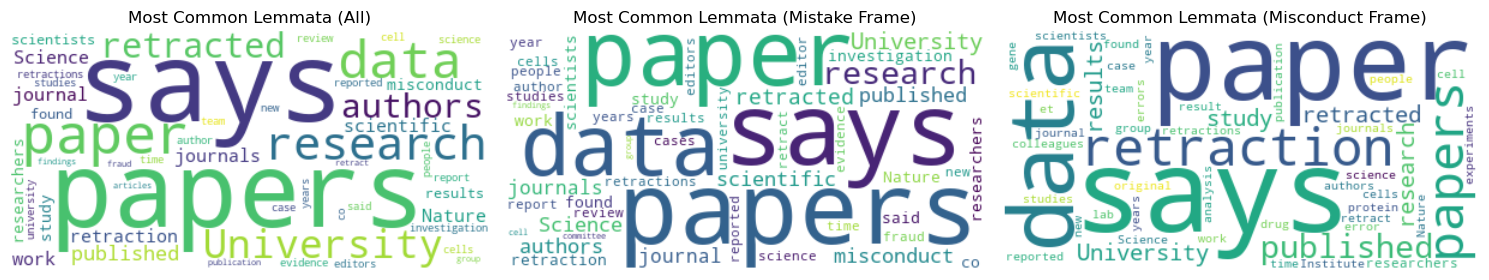

In [352]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Calculate value counts for each category
MC = df[df.category == "misconduct"]["NoStopwords"].explode().value_counts()[:50]
MT = df[df.category == "mistake"]["NoStopwords"].explode().value_counts()[:50]
All = df["NoStopwords"].explode().value_counts()[:50]

# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# List of word frequency Series and corresponding titles
word_freqs = [All, MC, MT]
titles = ['Most Common Lemmata (All)', 'Most Common Lemmata (Mistake Frame)', 'Most Common Lemmata (Misconduct Frame)']

# Generate and display each word cloud
for ax, word_freq, title in zip(axes, word_freqs, titles):
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')  # Hide the axes

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Keywords over time

In [354]:
# Resample by 4 years and aggregate
result = dfY.dropna(subset="keywords_likely").resample('5A').agg(
    joined_text=('text', lambda x: "".join(x)),
    joined_keywords=('keywords_likely', list),
    text_count=('text', 'count'))

result.joined_keywords_only=result.joined_keywords.apply(lambda x: [(j[0].lstrip("of"),j[1]) for i in x for j in i if "_" not in j[0]])


/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3035941781.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  result = dfY.dropna(subset="keywords_likely").resample('5A').agg(
/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/3035941781.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.joined_keywords_only=result.joined_keywords.apply(lambda x: [(j[0].lstrip("of"),j[1]) for i in x for j in i if "_" not in j[0]])


In [356]:
all_keywords=dfY.keywords_only.explode().to_list()

pattern=[i[0] for i in result.joined_keywords.explode().explode().to_list()]
from collections import Counter
most_common_keywords=[i[0] for i in Counter(all_keywords).most_common(50)]

most_common_keywords

['journal',
 'researcher',
 'publication',
 'misconduct',
 'investigation',
 'scientist',
 'research',
 'retraction',
 'scientific',
 'cell',
 'finding',
 'retracted',
 'vaccine',
 'fraud',
 'author',
 'studie',
 'science',
 'fraudulent',
 'gene',
 'plagiarism',
 'citation',
 'embryo',
 'lawsuit',
 'stem',
 'integrity',
 'biologist',
 'embryonic',
 'hwang',
 'editorial',
 'reviewer',
 'publishing',
 'fabricated',
 'cancer',
 'publisher',
 'physicist',
 'experiment',
 'dna',
 'psychologist',
 'genetic',
 'enzyme',
 'trial',
 'cloning',
 'pluripotency',
 'nuclear',
 'editor',
 'neutrino',
 'geneticist',
 'article',
 'patent',
 'retract']

In [358]:
d(300)
import re
pattern = re.compile('|'.join(map(re.escape, most_common_keywords)))

result["filtered_keywords"]=result.joined_keywords_only.apply(lambda x: [i for i in x if not pattern.search(i[0])])
result["filtered_keywords"] = result["filtered_keywords"].apply(lambda x: sorted(x, key=lambda y: y[1], reverse=True))
result["filtered_keywords"] = result["filtered_keywords"].apply(lambda x: list(dict.fromkeys([i[0] for i in x])))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 65.9 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [368]:
# Function to filter similar words in a list

#!python -m spacy download en_core_web_lg
import spacy
# Enable GPU support
spacy.prefer_gpu()

# Load the spaCy model with word vectors
nlp=spacy.load("en_core_web_lg")



# Function to filter similar words in a list and return their lemmas
def filter_similar_words(word_list):
    unique_words = []
    tokens = list(nlp.pipe(word_list))  # Process all words in the list at once
    for token in tokens:
        if token[0].pos_ == "NOUN":  # Check if the token is a noun
            if not any(token[0].similarity(existing_token) > 0.70 for existing_token in unique_words):
                unique_words.append(token[0])  # Store the lemma instead of the token
    unique_words=[token.lemma_ for token in unique_words]
    return unique_words  # Return the list of unique lemmas

# Apply the function to the DataFrame column
result["filtered_keywords_result"] = result["filtered_keywords"].progress_apply(filter_similar_words)


  0%|                                                    | 0/13 [00:00<?, ?it/s]/var/folders/xb/hcrlz1px0q5byjc3wrssw2lm0000gn/T/ipykernel_30746/162957477.py:19: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  if not any(token[0].similarity(existing_token) > 0.70 for existing_token in unique_words):
100%|███████████████████████████████████████████| 13/13 [00:01<00:00, 10.18it/s]


In [370]:
result[["filtered_keywords_result","filtered_keywords"]].sample(5)

,filtered_keywords_result,filtered_keywords
Date,,
1993-12-31,"[paleoanthropology, ullerene, hadproducedfunctioningmeaslesviruse, deforestation, schizophreniaworkershavegone, usion, review, libel, possiblehomosexuality, evidenceusingallbutthe, deuterium, accuser, inding, imanishi, neuropathology, galaxy, imanishikari, hydrogen, astronomer, inaccuracy, atleu...","[amyloid, amyloidprotein, tobehomosexual, paleoanthropology, ullerene, thatvirusespurportedlyproduced, multidrug, homosexual, hadproducedfunctioningmeaslesviruses, schizophrenia, alzheimer, deforestation, schizophreniaworkershavegone, usion, superconductingfullerenewith, reviews, smithsaidsevera..."
1963-12-31,[institute],"[institute, institutes]"
2023-12-31,"[harassment, mosquito, earthquake, bioethic, seismology, accountability, anaesthesiologist, mutation, transplantation, bservatory, bioethicist, ethic, consultancy, investigator, retaliation, anaesthetist, raud, donor, volcano, inding, discovery, schizophrenial3, mistake, consent, whistleblower, ...","[harassment, investigating, mosquitoes, mosquitoesweremore, mosquito, earthquake, investigated, raudulent, raudulently, crispr, chinapublished, geothermal, bioethics, seismology, accountability, nobel, anaesthesiologists, mutation, transplantation, bservatory, anaesthesiologist, awardedtocarlosl..."
1973-12-31,"[earthquake, seismicity, mediocrity, shock, accelerator, reconsideration, proton, committee, meteorite, moon, beisance, seismometer, bviouslyitisworthflatteringthose, criticism, crater, microscopy, scandal, slogan, molecule, nutrition, bomber, pesticide]","[earthquakes, earthquake, seismicity, aftershocks, mediocrity, shocks, accelerator, cern, reconsideration, acknowledgmentsareblatantlypolitical, galileo, proton, medvedev, lunar, committees, meteorite, moon, beisance, seismometer, bviouslyitisworthflatteringthose, criticisms, craters, microscopy..."
2013-12-31,"[supercomputer, perchlorate, defamation, wwpdbvalidationreport, stapel, mmrvaccination, triceratop, autism, nasutoceratop, iornsfoundedthereproducibilityinitiative, blog, proteincrystallographer, ssil, ssil, maize, simianretrovirus, extinction, programmer, pubpeer, genomicist, wwpdbvalidationtas...","[supercomputer, da, ukushima, perchlorate, abouthiscv, defamation, reactor, wwpdbvalidationreports, stapel, mmrvaccination, triceratops, autism, nasutoceratops, wakefieldworked, scalegenomicinformationto, plagiarized, iornsfoundedthereproducibilityinitiative, blogs, proteincrystallographer, ssil..."


In [372]:
result["filtered_keywords2"]=result["filtered_keywords_result"].apply(lambda x: list(dict.fromkeys([i for i in x if ((len(i)<14)&(len(i)>4))])))

import textwrap

result["keywords_wrapped"] = result["filtered_keywords2"].apply(
    lambda x: '\n'.join(textwrap.wrap(' '.join(x), width=2)))

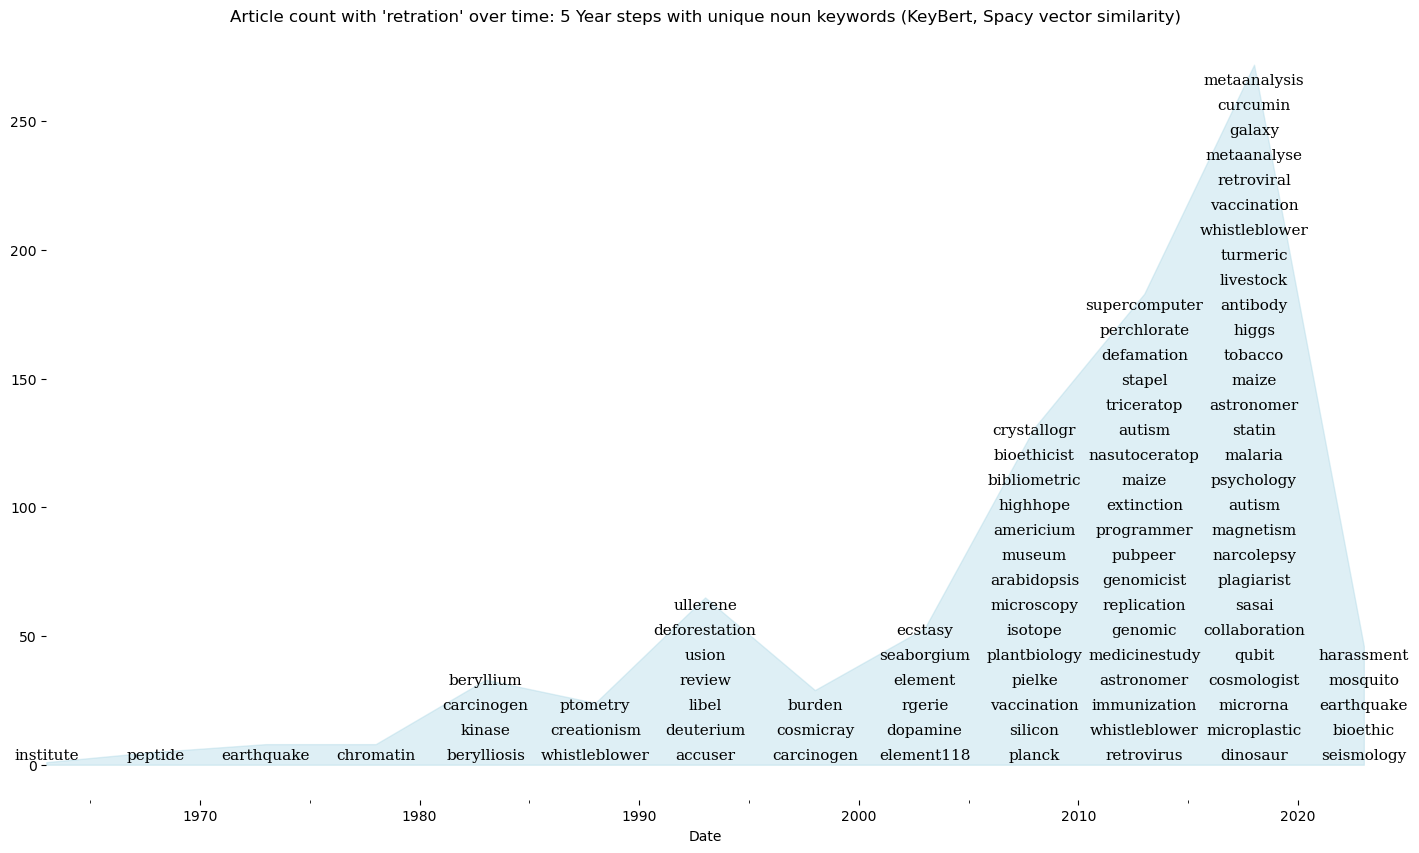

In [374]:
import matplotlib.pyplot as plt
import seaborn as sns
f=result.text_count.plot(figsize=(17,10),
                         title="Article count with 'retration' over time: 5 Year steps with unique noun keywords (KeyBert, Spacy vector similarity)",lw=0)

# Fill the area under the curve
plt.fill_between(result.index, result['text_count'], color='lightblue', alpha=0.4)

# Fill the area with keywords
for i, row in result.iterrows():
# Calculate the position for the keyword
    y_position = row['text_count'] / 2  # Position the keyword in the middle of the filled area
    n_words=int(row['text_count']*0.10)+1

    plt.text(i, 1, "\n".join(row['filtered_keywords2'][:n_words]), ha='center', va='bottom', fontsize=11, color='black', family='serif',linespacing=2)



sns.despine(left=True, bottom=True)
plt.show()

f.get_figure().savefig("history_keywords.pdf", bbox_inches='tight')